## Load Libraries

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
import tensorflow as tf
from skimage.transform import resize

C:\Users\jalil\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
print(tf.__version__)

2.15.0


In [12]:
image_dir = Path('/kaggle/input/food41/images')
SIZE = 224

In [3]:
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from pathlib import Path
import os.path
import seaborn as sns

In [4]:
i = 0
from skimage import img_as_ubyte
train_images = []
train_labels = [] 
for directory_path in glob.glob("C:/Users/jalil/OneDrive/Desktop/food image data/images/*"):
    if i==30:
        break
    i+=1
    label = directory_path.split("/")[-1]
    x = int(0)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_image(img, channels=3)

        # Resize the image to 224x224 pixels
        img = tf.image.resize(img, (224, 224))

        # Convert RGB to BGR
        img = tf.reverse(img, axis=[-1])  # Convert from RGB to BGR

        # Normalize pixel values to the range [-1, 1]
        img = tf.image.per_image_standardization(img)
        

        # Expand dimensions to match the model's input shape (batch_size, height, width, channels)
        train_images.append(img)
        train_labels.append(label)
        x = x + int(1)
        if x == int(100):
            break

In [5]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [6]:
i = 0
test_images = []
test_labels = [] 
for directory_path in glob.glob("C:/Users/jalil/OneDrive/Desktop/food image data/images/*"):
    if i==30:
        break
    i+=1
    label = directory_path.split("/")[-1]
    x = int(0)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        x = x +int(1)
        if x == int(100):
            break
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):    
        img = tf.io.read_file(img_path)
        img = tf.image.decode_image(img, channels=3)

        # Resize the image to 224x224 pixels
        img = tf.image.resize(img, (224, 224))

        # Convert RGB to BGR
        img = tf.reverse(img, axis=[-1])  # Convert from RGB to BGR

        # Normalize pixel values to the range [-1, 1]
        img = tf.image.per_image_standardization(img)
        # Expand dimensions to match the model's input shape (batch_size, height, width, channels)
        test_images.append(img)
        test_labels.append(label)
        x = x + int(1)
        if x == int(130):
            break

In [7]:
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [8]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [9]:
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [10]:
from keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [13]:
activation = 'sigmoid'

feature_extractor = Sequential()
feature_extractor.add(Conv2D(32, 3, activation = activation, padding = 'same', input_shape = (SIZE, SIZE, 1)))
feature_extractor.add(BatchNormalization())

feature_extractor.add(Conv2D(32, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D())

feature_extractor.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(MaxPooling2D())

feature_extractor.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(MaxPooling2D())

feature_extractor.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D())

feature_extractor.add(Flatten())

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

# Load the VGG16 base model (pre-trained on ImageNet)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model (optional)
for layer in base_model.layers:
    layer.trainable = False

# Create a custom head for your specific task
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
output = Dense(30, activation='softmax')(x)  # Adjust NUM_CLASSES as needed

# Create the final model by combining the base model and custom head
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


58889256/58889256 [==============================] - 2s 0us/step


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [15]:
x = feature_extractor.output  
x = Dense(128, activation = activation, kernel_initializer = 'he_uniform')(x)
prediction_layer = Dense(101, activation = 'softmax')(x)

In [16]:
cnn_model = Model(inputs=feature_extractor.input, outputs=prediction_layer)
cnn_model.compile(optimizer='rmsprop',loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(cnn_model.summary()) 

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 224, 224, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_1 (Bat  (None, 224, 224, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0   

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint
monitor_metric = 'val_accuracy'
checkpoint_callback = ModelCheckpoint('model_best.h5', 
                                       monitor=monitor_metric,
                                       save_best_only=True,
                                       mode='max',  # Use 'min' for loss and 'max' for accuracy
                                       verbose=1)


In [18]:
print(x_train.shape)

(3000, 224, 224, 3)


In [27]:
history = model.fit(x_train, y_train_one_hot, epochs=1, validation_data = (x_test, y_test_one_hot), callbacks=[checkpoint_callback])

94/94 [==============================] - ETA: 0s - loss: 0.0078 - accuracy: 1.0000
Epoch 1: val_accuracy did not improve from 1.00000
94/94 [==============================] - 229s 2s/step - loss: 0.0078 - accuracy: 1.0000 - val_loss: 0.0058 - val_accuracy: 1.0000


In [28]:
model.save('vgg30model.h5')

In [32]:
model1 = tf.keras.models.load_model('vgg30model.h5')


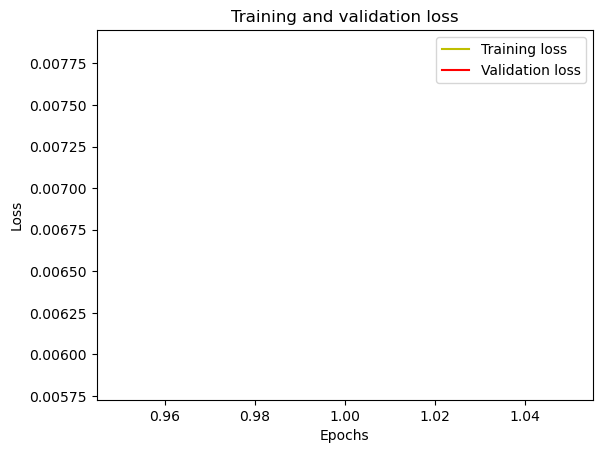

In [33]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


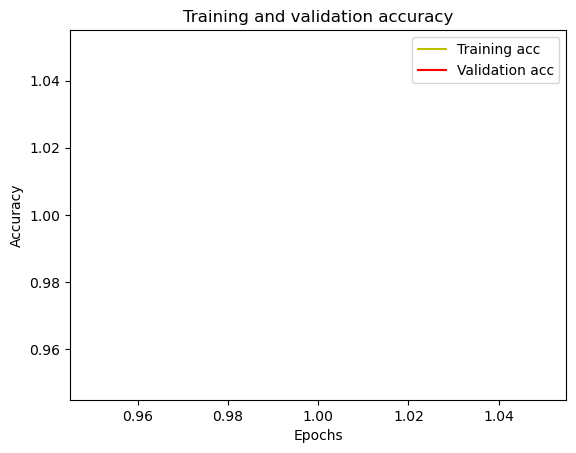

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [35]:
prediction_NN = model1.predict(x_test)
prediction_NN = np.argmax(prediction_NN, axis=-1)
prediction_NN = le.inverse_transform(prediction_NN)

29/29 [==============================] - 48s 2s/step


[[30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 30  0  0  0  0  0 

<Axes: >

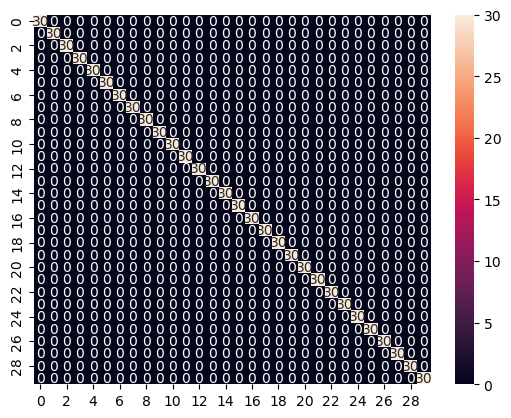

In [36]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, prediction_NN)
print(cm)
sns.heatmap(cm, annot=True)

1/1 [==============================] - 0s 129ms/step
The prediction for this image is:  ['images\\caesar_salad']
The actual label for this image is:  images\caesar_salad


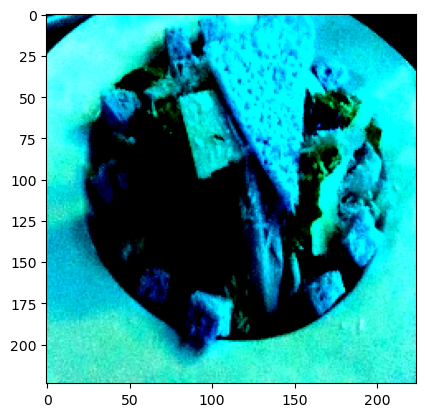

In [37]:
n=345
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) 
prediction = np.argmax(model1.predict(input_img))  
prediction = le.inverse_transform([prediction]) 
print("The prediction for this image is: ", prediction)
print("The actual label for this image is: ", test_labels[n])

1/1 [==============================] - 0s 124ms/step
The prediction for this image is:  ['images\\baby_back_ribs']
The actual label for this image is:  images\baby_back_ribs


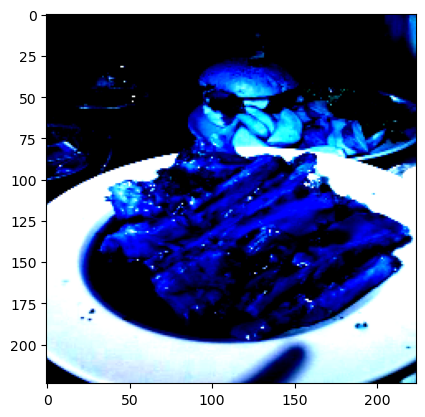

In [38]:
n=33
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) 
prediction = np.argmax(model1.predict(input_img))  
prediction = le.inverse_transform([prediction]) 
print("The prediction for this image is: ", prediction)
print("The actual label for this image is: ", test_labels[n])

In [44]:
# Predict one image from a path
def predict_one_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (SIZE, SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.array(img)
    img = img.astype('float32')
    img /= 255
    plt.imshow(img)
    input_img = np.expand_dims(img, axis=0) 
    prediction = np.argmax(model1.predict(input_img))  
    prediction = le.inverse_transform([prediction]) 
    print("The prediction for this image is: ", prediction)

1/1 [==============================] - 0s 116ms/step
The prediction for this image is:  ['images\\caesar_salad']


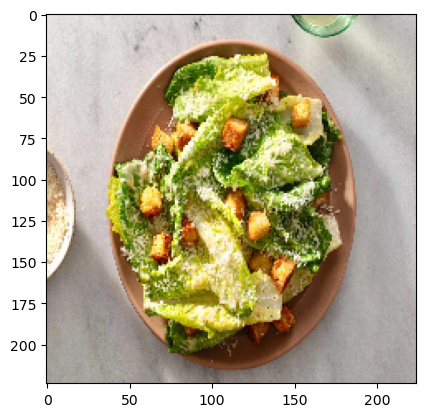

In [45]:
predict_one_image("C:/Users/jalil/OneDrive/Desktop/food image data/test/cesar_test.jpg")